### Installing and Importing Modules 

In [ ]:
#pip install pandas
#pip install matplotlib
#pip install numpy
#pip install seaborn
#pip install scipy
#pip install statsmodels

In [389]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Enter number of years, data source path and folder destination path 

In [390]:
# input a number
while True:
  try:
    nbr = int(input("Enter an integer number to design the number of years for the prediction: "))
    break
  except ValueError:
      print("Please input integer only...")  
      continue

Enter an integer number to design the number of years for the prediction: 5


In [416]:
while True:
  try:
    source_path = str(input("Enter a string to design the path of your excel data source: "))
    break
  except ValueError:
      print("Please input string only...")  
      continue

Enter a string to design the path of your excel data source: C:/Users/abidm/Desktop/Jalila/Datasource_AllMarket_PourProjection.xlsx


In [392]:
while True:
  try:
    dest_path = str(input("Enter a string to design the folder path in which you want to put the outputs in: "))
    break
  except ValueError:
      print("Please input string only...")  
      continue

Enter a string to design the folder path in which you want to put the outputs in: C:/Users/abidm/Desktop/Jalila


In [417]:
print(source_path)
print(dest_path)

C:/Users/abidm/Desktop/Jalila/Datasource_AllMarket_PourProjection.xlsx
C:/Users/abidm/Desktop/Jalila


### Importing data

In [419]:
data=pd.read_excel(source_path)

In [420]:
df=data.copy()

### Fixing Problem of input: MAT not correct (at index 13,14,15)

In [421]:
df['verif_mk']=df['Quarter Turnover Market Base Business'].rolling(4).sum()
df['verif_mk']=df['verif_mk'].astype('Int64') 

In [422]:
df['MAT Turnover Market Base Business'][13:16]=df['verif_mk'][13:16]

<ipython-input-422-a098c4e52b70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MAT Turnover Market Base Business'][13:16]=df['verif_mk'][13:16]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Fixing anomaly for future prediction (at 2020 T2, index=42)

In [423]:
#Correcting anomaly for future prediction (at 2020 T2)
df['Quarter Turnover Market Base Business'][42]=int((df['Quarter Turnover Market Base Business'][30]+df['Quarter Turnover Market Base Business'][34]+df['Quarter Turnover Market Base Business'][38])/3)

<ipython-input-423-a7dea6023d46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quarter Turnover Market Base Business'][42]=int((df['Quarter Turnover Market Base Business'][30]+df['Quarter Turnover Market Base Business'][34]+df['Quarter Turnover Market Base Business'][38])/3)


### On entraine le modele sur tout le signal et on fait la prédiction Quarter sur 5 ans

In [424]:
train_data = df['Quarter Turnover Market Base Business'][:len(df)-1]

In [425]:
my_order = (0,0,0) #(000,1014)(2, 0, 2, 4)
my_seasonal_order = (2, 0, 2, 4)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()

In [426]:
predictions = model_fit.get_forecast(steps=nbr*4+1)

### Prediction chiffre affaire sur 5ans

In [427]:
df_new=df[['Trimestre de Date','MAT Turnover Market Base Business','Quarter Turnover Market Base Business']]
df_new['upper_quarter']=df_new['Quarter Turnover Market Base Business']
df_new['lower_quarter']=df_new['Quarter Turnover Market Base Business']

<ipython-input-427-04db058d2f4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['upper_quarter']=df_new['Quarter Turnover Market Base Business']
<ipython-input-427-04db058d2f4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['lower_quarter']=df_new['Quarter Turnover Market Base Business']


In [428]:
last=df['Trimestre de Date'][len(df)-1].split(' T')
list_year=[int(last[0])]
list_quarter=[int(last[1])]
for i in range(nbr*4):
    list_quarter.append(list_quarter[-1]%4+1)
    list_year.append(list_year[-1]+(list_quarter[-1]==1))
del list_year[0]
del list_quarter[0]
print(list_year)
print(list_quarter)      

[2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023, 2024, 2024, 2024, 2024, 2025, 2025, 2025, 2025]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]


In [429]:
test = pd.DataFrame({'Year':list_year,'Quarter':list_quarter})
# test["Trimestre de Date"] = str(test["Year"])#+ str(test["Quarter"])
test['Year']=test['Year'].astype(str)
test['Quarter']=test['Quarter'].astype(str)
test["Trimestre de Date"] = test["Year"]+ ' T' +test["Quarter"]
value_list=test["Trimestre de Date"].tolist()

In [430]:
key_list = [*range(nbr*4)]
key_list = [x+len(df) for x in key_list]

In [431]:
zip_iterator = zip(key_list, value_list)
dictio = dict(zip_iterator)
for key,value in dictio.items():
    new_row = {'Trimestre de Date':value, 'MAT Turnover Market Base Business':-1, 'Quarter Turnover Market Base Business':predictions.predicted_mean[key],'upper_quarter':predictions.conf_int(alpha=0.05)['upper Quarter Turnover Market Base Business'][key],'lower_quarter':predictions.conf_int(alpha=0.05)['lower Quarter Turnover Market Base Business'][key]}
    df_new = df_new.append(new_row, ignore_index=True)

df_new['upper_mat']=df_new['MAT Turnover Market Base Business']
df_new['lower_mat']=df_new['MAT Turnover Market Base Business']
df_new.tail()

,Trimestre de Date,MAT Turnover Market Base Business,Quarter Turnover Market Base Business,upper_quarter,lower_quarter,upper_mat,lower_mat
60,2024 T4,-1,3.160856e+08,3.325726e+08,2.995986e+08,-1,-1
61,2025 T1,-1,3.171179e+08,3.336049e+08,3.006309e+08,-1,-1
62,2025 T2,-1,3.133482e+08,3.298352e+08,2.968613e+08,-1,-1
63,2025 T3,-1,3.017356e+08,3.182226e+08,2.852486e+08,-1,-1
64,2025 T4,-1,3.167706e+08,3.346433e+08,2.988979e+08,-1,-1


In [432]:
df_new.tail(nbr*4+1)

,Trimestre de Date,MAT Turnover Market Base Business,Quarter Turnover Market Base Business,upper_quarter,lower_quarter,upper_mat,lower_mat
44,2020 T4,1216740000,3.294510e+08,3.294510e+08,3.294510e+08,1216740000,1216740000
45,2021 T1,-1,3.172141e+08,3.256047e+08,3.088234e+08,-1,-1
46,2021 T2,-1,3.133957e+08,3.217864e+08,3.050050e+08,-1,-1
47,2021 T3,-1,3.018650e+08,3.102557e+08,2.934743e+08,-1,-1
48,2021 T4,-1,3.168950e+08,3.277483e+08,3.060417e+08,-1,-1
49,2022 T1,-1,3.170990e+08,3.279524e+08,3.062457e+08,-1,-1
50,2022 T2,-1,3.143955e+08,3.252488e+08,3.035421e+08,-1,-1
51,2022 T3,-1,3.008680e+08,3.117213e+08,2.900147e+08,-1,-1
52,2022 T4,-1,3.161154e+08,3.291970e+08,3.030339e+08,-1,-1
53,2023 T1,-1,3.171659e+08,3.302475e+08,3.040844e+08,-1,-1


In [433]:
df_new['MAT Turnover Market Base Business'][len(df):]=df_new['Quarter Turnover Market Base Business'].rolling(4).sum()[len(df):]
df_new['upper_mat'][len(df):]=df_new['upper_quarter'].rolling(4).sum()[len(df):]
df_new['lower_mat'][len(df):]=df_new['lower_quarter'].rolling(4).sum()[len(df):]

<ipython-input-433-489fc5bb696e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['MAT Turnover Market Base Business'][len(df):]=df_new['Quarter Turnover Market Base Business'].rolling(4).sum()[len(df):]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-433-489fc5bb696e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [434]:
df_new['dist_conf']=df_new['upper_mat']-df_new['lower_mat']

In [435]:
df_new.tail(nbr*4+1)

,Trimestre de Date,MAT Turnover Market Base Business,Quarter Turnover Market Base Business,upper_quarter,lower_quarter,upper_mat,lower_mat,dist_conf
44,2020 T4,1.216740e+09,3.294510e+08,3.294510e+08,3.294510e+08,1.216740e+09,1.216740e+09,0.000000e+00
45,2021 T1,1.262280e+09,3.172141e+08,3.256047e+08,3.088234e+08,1.270671e+09,1.253890e+09,1.678135e+07
46,2021 T2,1.261097e+09,3.133957e+08,3.217864e+08,3.050050e+08,1.277878e+09,1.244315e+09,3.356269e+07
47,2021 T3,1.261926e+09,3.018650e+08,3.102557e+08,2.934743e+08,1.287098e+09,1.236754e+09,5.034404e+07
48,2021 T4,1.249370e+09,3.168950e+08,3.277483e+08,3.060417e+08,1.285395e+09,1.213344e+09,7.205068e+07
49,2022 T1,1.249255e+09,3.170990e+08,3.279524e+08,3.062457e+08,1.287743e+09,1.210767e+09,7.697598e+07
50,2022 T2,1.250255e+09,3.143955e+08,3.252488e+08,3.035421e+08,1.291205e+09,1.209304e+09,8.190128e+07
51,2022 T3,1.249258e+09,3.008680e+08,3.117213e+08,2.900147e+08,1.292671e+09,1.205844e+09,8.682658e+07
52,2022 T4,1.248478e+09,3.161154e+08,3.291970e+08,3.030339e+08,1.294119e+09,1.202836e+09,9.128305e+07
53,2023 T1,1.248545e+09,3.171659e+08,3.302475e+08,3.040844e+08,1.296415e+09,1.200675e+09,9.573951e+07


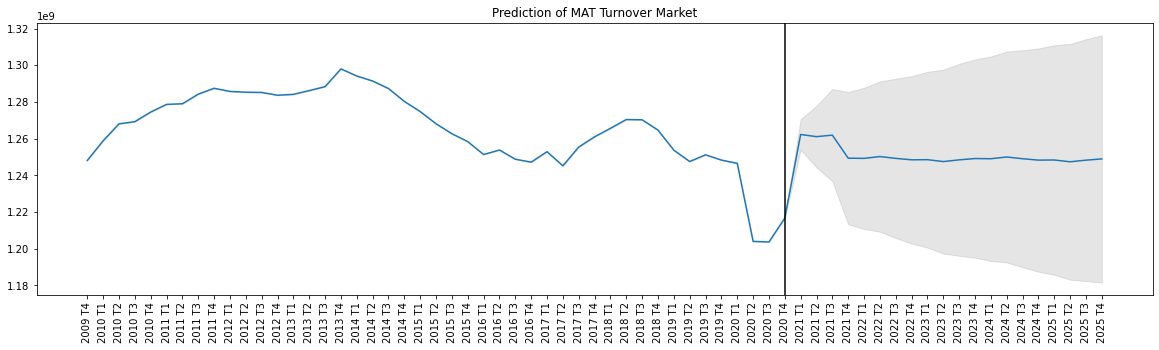

In [436]:
plt.figure(figsize=(20,5))
plt.title('Prediction of MAT Turnover Market')
plt.plot(df_new['Trimestre de Date'],df_new['MAT Turnover Market Base Business'])
plt.xticks(rotation=90)
# plt.plot(predictions.predicted_mean)
# plt.plot(predictions.conf_int(alpha=0.05))

plt.fill_between(df_new['Trimestre de Date'], df_new['upper_mat'], df_new['lower_mat'], color='grey',alpha=.2)
plt.axvline(x=df['Trimestre de Date'][len(df)-1],color='black')

plt.savefig(dest_path+"/Predictions_Graphe.png", bbox_inches='tight')

# plt.legend(('Data', 'Predictions','Confidence'), fontsize=10,loc="lower left")

In [437]:
df_new.to_excel(dest_path+"/Predictions_Table.xlsx",index=False)